# Lag-Llama: Towards Foundation Models for Probabilistic Time Series Forecasting

![lag-llama-architecture](https://raw.githubusercontent.com/time-series-foundation-models/lag-llama/main/images/lagllama.webp)

Lag-Llama is the <b>first open-source foundation model for time series forecasting</b>!

[[Tweet Thread](https://twitter.com/arjunashok37/status/1755261111233114165)] [[Model Weights](https://huggingface.co/time-series-foundation-models/Lag-Llama)] [[Colab Demo on Zero-Shot Forecasting](https://colab.research.google.com/drive/1XxrLW9VGPlZDw3efTvUi0hQimgJOwQG6?usp=sharing)] [[GitHub](https://github.com/time-series-foundation-models/lag-llama)] [[Paper](https://arxiv.org/abs/2310.08278)]

💫 This Colab Demo shows you how to use the pretrained Lag-Llama model to get zero-shot predictions on time series.


**Please make a copy of this notebook if you would like to save your changes (File -> Save a copy in ...)**




# Update 17/Feb

We have made a new Colab to show to **how one can load time series in different formats**. Check it out [here](https://colab.research.google.com/drive/1XxrLW9VGPlZDw3efTvUi0hQimgJOwQG6?usp=sharing)!


# Demo

We first clone and install the required packages from the [GitHub repository](https://github.com/time-series-foundation-models/lag-llama/) that has the Lag-Llama architecture.



In [ ]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 34 (delta 5), reused 32 (delta 3), pack-reused 0
Receiving objects: 100% (34/34), 160.07 KiB | 32.01 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
cd lag-llama

/content/lag-llama


In [ ]:
!pip install -r requirements.txt --quiet # this could take some time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 

We then download our pretrained model weights from [HuggingFace](https://huggingface.co/time-series-foundation-models/Lag-Llama) 🤗

In [ ]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmp09k6lk76
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 137MB/s]
/content/lag-llama/lag-llama.ckpt


We import the required packages and the lag llama estimator object which we can use to make predictions.

In [ ]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from lag_llama.gluon.estimator import LagLlamaEstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

We download the [Melbourne Pedestrian Counts](https://zenodo.org/records/3898350) dataset used in our [paper](https://time-series-foundation-models.github.io/lag-llama.pdf). This is a dataset that the model has never seen before.

We then set the forecast length of the dataset for inference. Here we use the default prediction length of the dataset (48).

Note how the frequency of the dataset does not matter, since lag-llama can (train and) perform inference with any data of any frequency.

In [ ]:
dataset = get_dataset("pedestrian_counts")

backtest_dataset = dataset.test
prediction_length = dataset.metadata.prediction_length
context_length = 32

Download pedestrian_counts_dataset.zip:: 4.38MB [00:03, 1.42MB/s]
creating json files: 100%|██████████| 66/66 [00:00<00:00, 109850.82it/s]


We create a model object with the hyperparameters from the pretrained model, and the prediction length.

In [ ]:
ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cuda:0'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

In [ ]:
estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,

    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
)

lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

We perform inference on this dataset zero-shot!

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=predictor,
)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

We obtain some metrics for our reference. The CRPS metric is a commonly used metric in time series forecasting literature. We obtain a CRPS of **0.2531** with this dataset (close to the number reported in Table 1 of the [paper](https://time-series-foundation-models.github.io/lag-llama.pdf)).

In [ ]:
evaluator = Evaluator()

In [ ]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 66it [00:00, 1823.14it/s]


In [ ]:
print("CRPS:", agg_metrics['mean_wQuantileLoss'])

CRPS: 0.25315461957426805


We plot the forecasts of our model on this dataset.

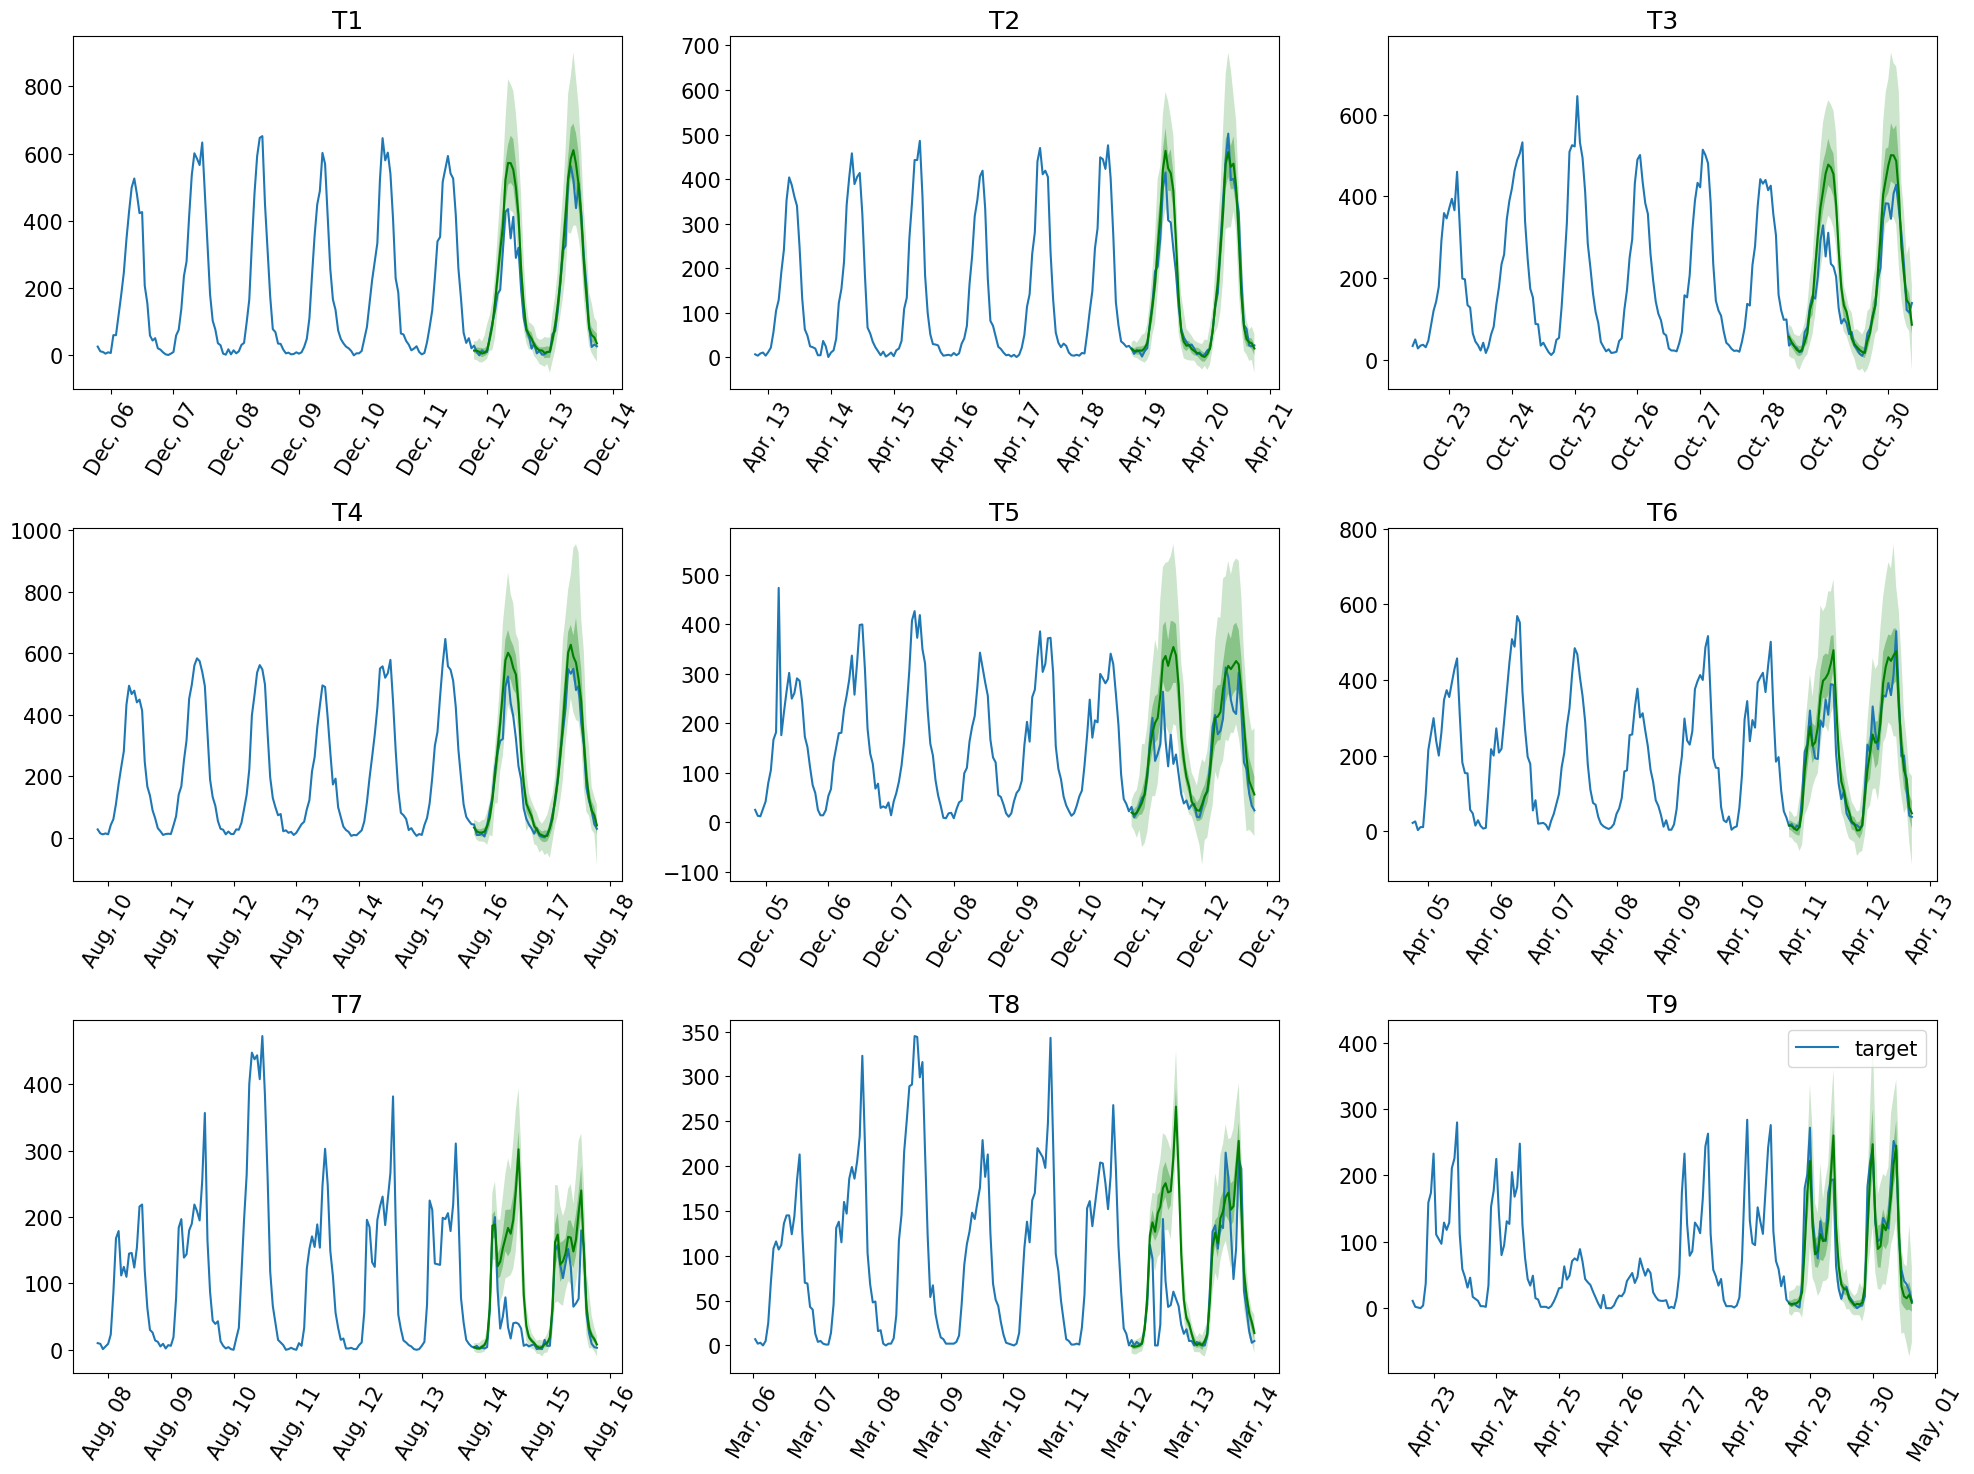

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()